## Supervised Learning
## Project: Finding Donors for *CharityML*


In this project, I will employ several supervised algorithms of my choice to accurately model individuals' income using data collected from the 1994 U.S. Census. I will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. My goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income).

----
## Exploring the Data


In [6]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))


age   workclass education_level  education-num  marital-status  \
0   39   State-gov       Bachelors           13.0   Never-married   

      occupation    relationship    race    sex  capital-gain  capital-loss  \
0   Adm-clerical   Not-in-family   White   Male        2174.0           0.0   

   hours-per-week  native-country income  
0            40.0   United-States  <=50K

### Implementation: Data Exploration


In [7]:
# Total number of records


n_records = len(data["income"])
    
# Number of records where individual's income is more than $50,000
z=0
w=0
for i in data['income']:    
    if i=='>50K':
        z+=1
    else:
        w+=1
n_greater_50k = z

# Number of records where individual's income is at most $50,000
n_at_most_50k = w

# Percentage of individuals whose income is more than $50,000
greater_percent = n_greater_50k /n_records*100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
For this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted.

### Transforming Skewed Continuous Features



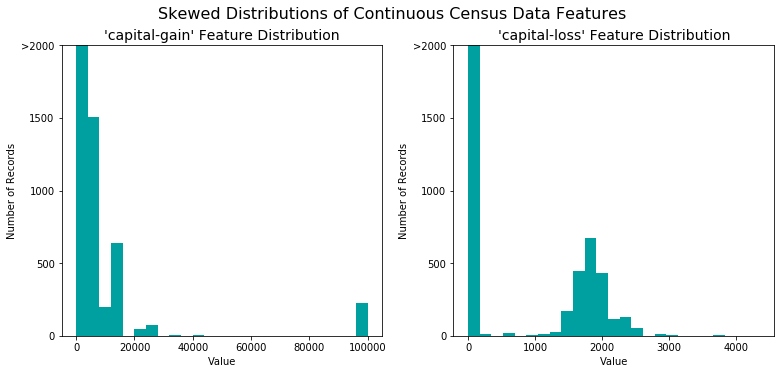

In [8]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

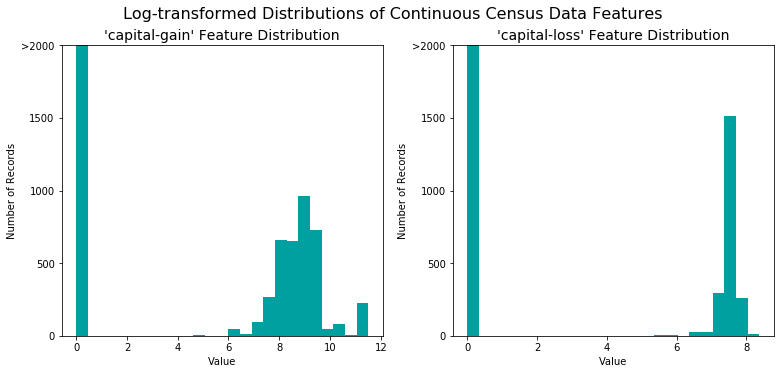

In [9]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features


In [10]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

age          workclass education_level  education-num  \
0  0.301370          State-gov       Bachelors       0.800000   
1  0.452055   Self-emp-not-inc       Bachelors       0.800000   
2  0.287671            Private         HS-grad       0.533333   
3  0.493151            Private            11th       0.400000   
4  0.150685            Private       Bachelors       0.800000   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital-gain  capital-loss  hours-per-week  native-country  
0      0.667492           0.0        0.397959   United-States  
1      0.000000           0.0        0.122449   United-States  
2      0.000000           0.0        0.397959   United-States  
3      0.000000           0.0        0.397959   United-States  
4      0.000000           0.0        0.397959            Cuba

### Implementation: Data Preprocessing


In [11]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# Encode the 'income_raw' data to numerical values

income = income_raw.map({'<=50K':0,'>50K':1})

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
print (encoded)

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### Shuffle and Split Data


In [12]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


##  Supervised Learning Models


### Implementation - Creating a Training and Predicting Pipeline


In [14]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[: sample_size], y_train[: sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end-start
        
    # Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[: 300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[: 300], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[: 300], predictions_train, beta=1)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=1)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation


LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.
DecisionTreeClassifier trained on 361 samples.
DecisionTreeClassifier trained on 3617 samples.
DecisionTreeClassifier trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.


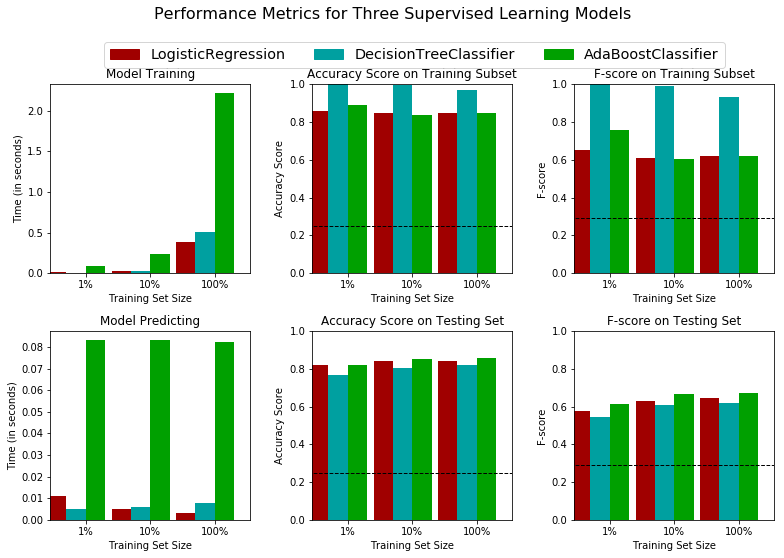

In [15]:
# Import the three supervised learning models from sklearn
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

# Initialize the three models
clf_A = LogisticRegression()
clf_B = DecisionTreeClassifier()
clf_C = AdaBoostClassifier()

# Calculate the number of samples for 1%, 10%, and 100% of the training data
# samples_100 is the entire training set i.e. len(y_train)
# samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
samples_10 = int(0.1*samples_100)
samples_1 = int(0.01*samples_100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results


### Model Tuning


In [16]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score

# Initialize the classifier
clf = AdaBoostClassifier()

# Create the parameters list you wish to tune, using a dictionary if needed.
parameters = {'n_estimators': [10, 100, 200], 
             'learning_rate': [0.001, 0.01, 0.1, 1, 2, 20]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer (fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sk

Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.7246

Optimized Model
------
Final accuracy score on the testing data: 0.8651
Final F-score on the testing data: 0.7396


----
## Feature Importance



### Extracting Feature Importance


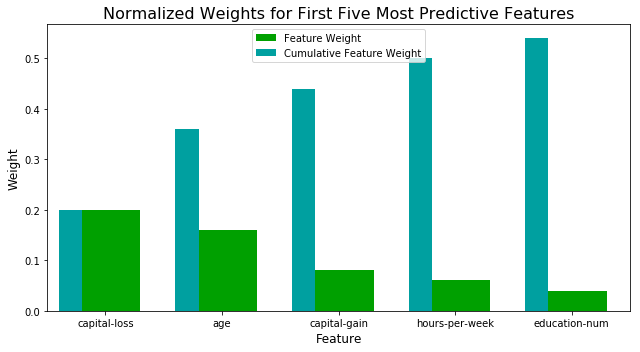

In [17]:
# Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier

# Train the supervised model on the training set using .fit(X_train, y_train)
model = AdaBoostClassifier().fit(X_train, y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Feature Selection


In [18]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8651
F-score on testing data: 0.7396

Final Model trained on reduced data
------
Accuracy on testing data: 0.8385
F-score on testing data: 0.6920
